In [2]:
##module references
import json
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import h3
from shapely.geometry import Polygon, MultiPolygon, mapping
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from shapely import wkt
import contextily as ctx
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from matplotlib import patches
from scipy.stats import wilcoxon,norm

##own module references
import sys

# Add the path to the Python module folder
script_path = '/Users/yaqifan/Documents/Github/Pyxis/scripts_n_notebooks'
if script_path not in sys.path:
  sys.path.insert(0, script_path)
from utils.analysis_util import load_opgee_results
from utils.path_util import DATA_PATH

##plot font
plt.rcParams['font.family'] = 'Arial'

## Plot for the match shape compare

/Users/yaqifan/Documents/Github/Pyxis/scripts_n_notebooks/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yaqifan/Documents/Github/Pyxis/scripts_n_notebooks/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yaqifan/Documents/Github/Pyxis/scripts_n_notebooks/.venv/lib/python3.11/site-packages/geopandas/geo

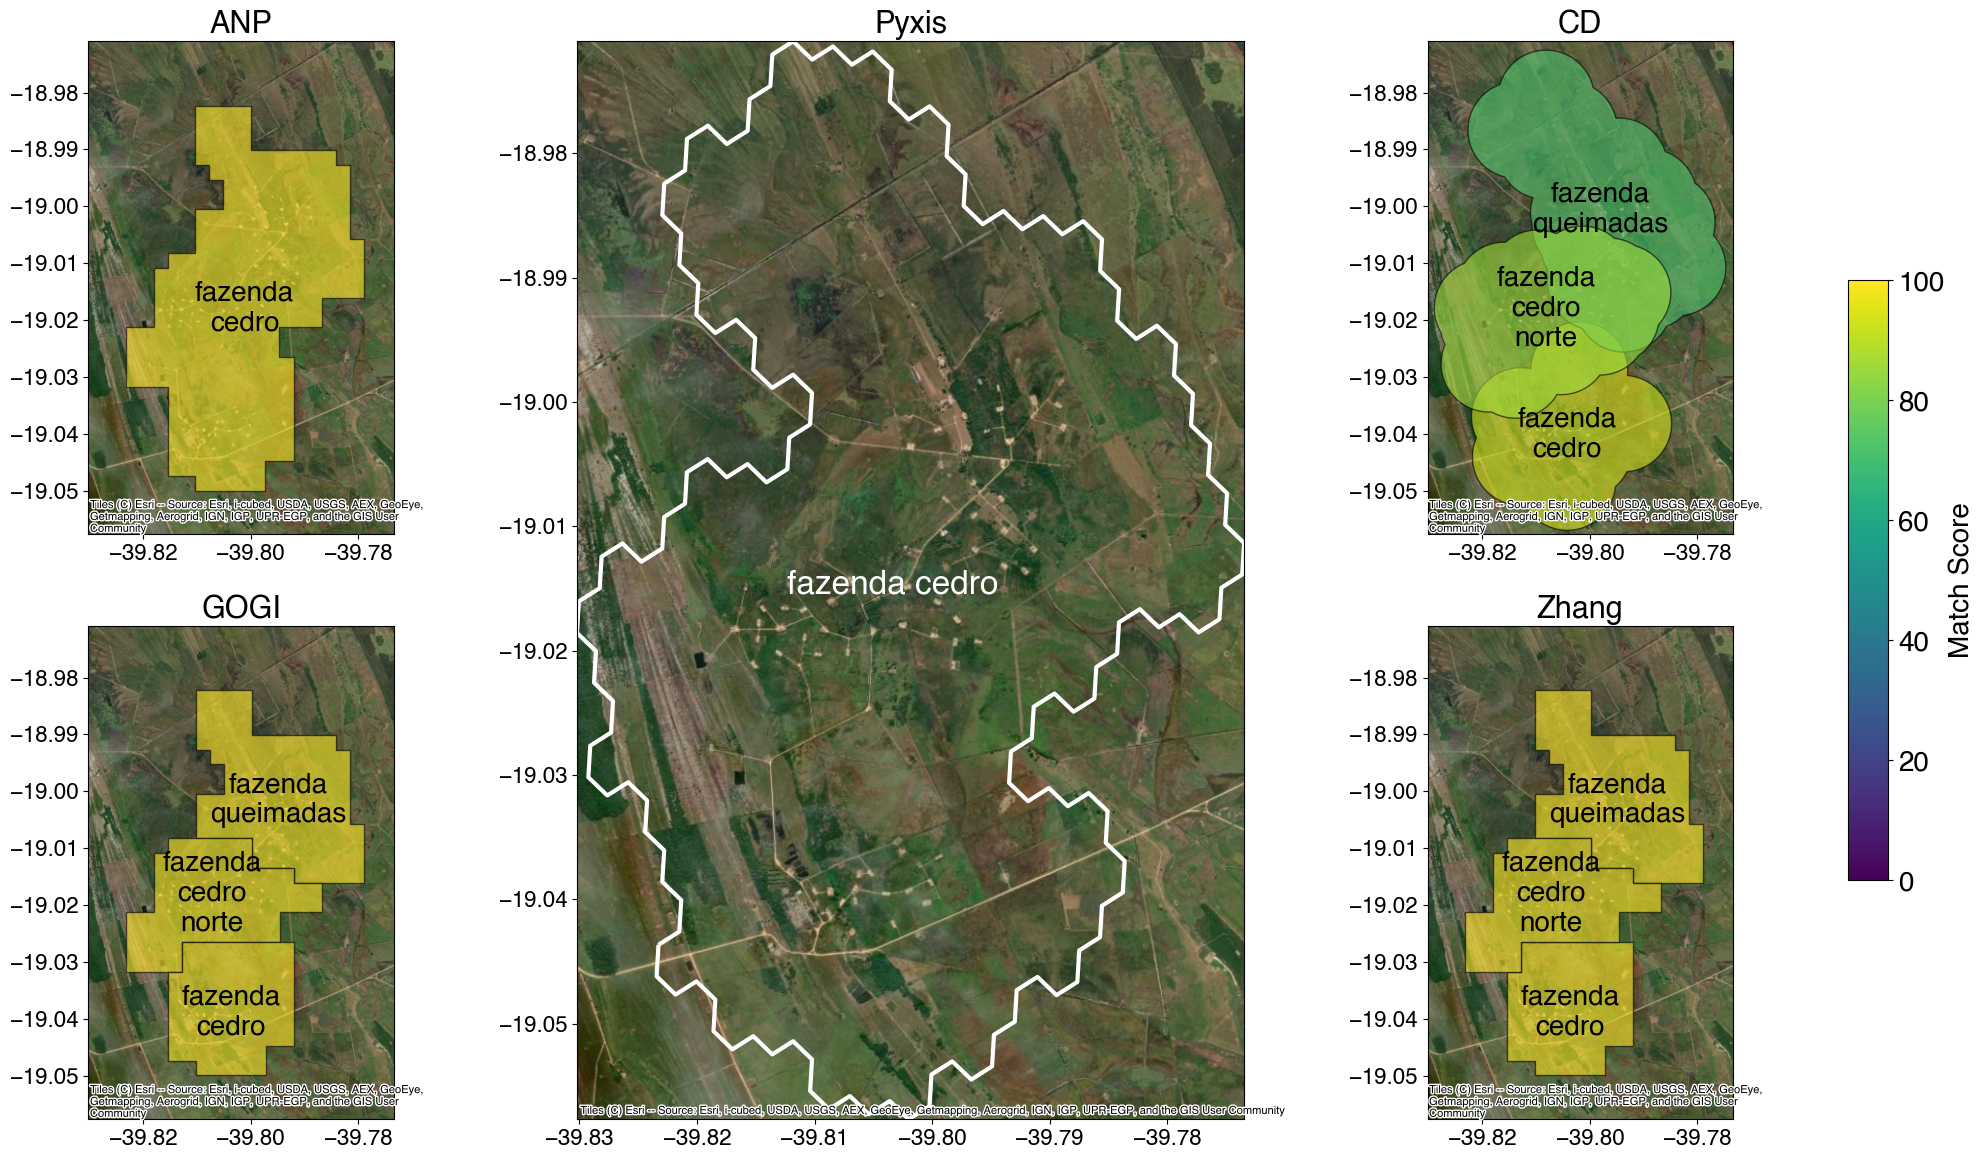

In [2]:
##prepare h3 boundary
# Load the CSV file with your original data
merged = pd.read_csv(f'{DATA_PATH}/br_geodata/merged_pyxis_field_info_table_filtered_withwm.csv')

# Parse the geometries (assuming they are WKT strings)
merged['geometry'] = merged['geometry'].apply(lambda x: gpd.GeoSeries.from_wkt([x])[0])

# Set the CRS to EPSG:4326 (latitude and longitude)
merged = gpd.GeoDataFrame(merged, geometry='geometry', crs="EPSG:4326")

# Function to handle both Polygon and MultiPolygon geometries
def dissolve_h3_boundary(geometry, resolution=9):
    h3_polygons = []
    
    # Handle MultiPolygon or single Polygon
    if isinstance(geometry, MultiPolygon):
        for polygon in geometry.geoms:  # Use .geoms to iterate over individual polygons in MultiPolygon
            h3_polygons.extend(polygon_to_h3_cells(polygon, resolution))
    elif isinstance(geometry, Polygon):
        h3_polygons.extend(polygon_to_h3_cells(geometry, resolution))
    
    # Dissolve the individual H3 polygons into a single shape
    if h3_polygons:
        dissolved_shape = unary_union(h3_polygons)
        return dissolved_shape
    return None

# Helper function to convert a single Polygon to H3 cells
def polygon_to_h3_cells(polygon, resolution=9):
    geojson_dict = mapping(polygon)
    h3_cells = h3.polyfill(geojson_dict, resolution)
    
    # Convert H3 cells to polygons while ensuring correct [longitude, latitude] order
    return [Polygon([(lng, lat) for lat, lng in h3.h3_to_geo_boundary(cell, geo_json=True)]) for cell in h3_cells]

# Apply the conversion for each field geometry
merged['dissolved_geometry'] = merged['geometry'].apply(dissolve_h3_boundary)

# Convert the results into a GeoDataFrame with CRS set to EPSG:4326
gdf = gpd.GeoDataFrame(merged, geometry='dissolved_geometry', crs="EPSG:4326")


### prepare match fields 
# Set font globally
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 20

# Load the Pyxis match table (replace with your actual CSV file path)
match_table = pd.read_csv(f'{DATA_PATH}/br_geodata/pyxis_match_table_filtered_withwm.csv')
id =  177
# Filter for Pyxis ID 93
pyxis_93_matches = match_table[match_table['Pyxis ID'] == id]

# Load the source data
anp_data = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/anp.csv')
wm_data = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/wm.csv')
zhan_data = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/zhan.csv')
gogi_data = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/gogi.csv')

# Convert the 'geometry' column from WKT format to actual geometry object
anp_data['geometry'] = anp_data['geometry'].apply(wkt.loads)
wm_data['geometry'] = wm_data['geometry'].apply(wkt.loads)
zhan_data['geometry'] = zhan_data['geometry'].apply(wkt.loads)
gogi_data['geometry'] = gogi_data['geometry'].apply(wkt.loads)

# Convert DataFrames to GeoDataFrames
anp_gdf = gpd.GeoDataFrame(anp_data, geometry='geometry', crs="EPSG:4326")
wm_gdf = gpd.GeoDataFrame(wm_data, geometry='geometry', crs="EPSG:4326")
zhan_gdf = gpd.GeoDataFrame(zhan_data, geometry='geometry', crs="EPSG:4326")
gogi_gdf = gpd.GeoDataFrame(gogi_data, geometry='geometry', crs="EPSG:4326")

# Load the H3 Pyxis data (replace with your actual GeoJSON file path)
br_h3 = gdf

# Filter the H3 data for Pyxis ID 93
h3_pyxis_93 = br_h3[br_h3['Pyxis ID'] == id]

# Extract relevant names for labeling (only the first name split by a comma)
field_names = [name.split(',')[0] for name in pyxis_93_matches['Name'].unique()]

# Extract original field shapes and match scores for the four sources
source_data = {
    'anp': {'gdf': anp_gdf, 'label': 'ANP'},
    'wm': {'gdf': wm_gdf, 'label': 'WM'},
    'zhan': {'gdf': zhan_gdf, 'label': 'Zhan'},
    'gogi': {'gdf': gogi_gdf, 'label': 'GOGI'}
}

# Filter each GeoDataFrame for the relevant field IDs
for source_name, data in source_data.items():
    source_matches = pyxis_93_matches[pyxis_93_matches['Source Name'] == source_name]
    field_ids = source_matches['Field ID'].tolist()
    data['filtered_gdf'] = data['gdf'][data['gdf']['Field ID'].isin(field_ids)]
    # Add match score as a column for colormap
    data['filtered_gdf']['match_score'] = source_matches.set_index('Field ID').loc[field_ids, 'Match Score']

### plots
# Create the figure
fig = plt.figure(figsize=(20, 12))

# Use subplot2grid to create the layout
ax1 = plt.subplot2grid((2, 4), (0, 1), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 0))
ax3 = plt.subplot2grid((2, 4), (0, 3))
ax4 = plt.subplot2grid((2, 4), (1, 0))
ax5 = plt.subplot2grid((2, 4), (1, 3))
axes = [ax1, ax2, ax3, ax4, ax5]

# Set the extent for all plots
ax1.set_xlim(h3_pyxis_93.total_bounds[[0, 2]])
ax1.set_ylim(h3_pyxis_93.total_bounds[[1, 3]])

# Add the basemap for ax1 before plotting the data
ctx.add_basemap(ax1, source=ctx.providers.Esri.WorldImagery, crs="EPSG:4326", zoom=14)
# Adjust label positions to avoid overlap in ax1
ax1.tick_params(labelsize=16)
centroid = h3_pyxis_93.geometry.centroid.iloc[0]
ax1.text(centroid.x, centroid.y, field_names[0], fontsize=24, ha='center', color='white', weight='bold', transform=ax1.transData)

# Now plot the H3 Pyxis field on ax1 with edge color only
h3_pyxis_93.plot(ax=ax1, facecolor='none', edgecolor='white', linewidth=3)

# Apply the same x and y limits to all other plots and add the basemap before plotting the data
for ax, (source_name, data) in zip([ax2, ax3, ax4, ax5], source_data.items()):
    ax.tick_params(labelsize=16)
    ax.set_xlim(ax1.get_xlim())  # Apply x limits before adding basemap
    ax.set_ylim(ax1.get_ylim())  # Apply y limits before adding basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="EPSG:4326", zoom=14)  # Add basemap
    data['filtered_gdf'].plot(ax=ax, column='match_score', cmap=plt.cm.viridis, edgecolor='black', linewidth=1, legend=False, norm=mcolors.Normalize(vmin=0, vmax=100), alpha=0.6)

    # Add the field name labels
    for idx, row in data['filtered_gdf'].iterrows():
        field_name = pyxis_93_matches[(pyxis_93_matches['Source Name'] == source_name) & (pyxis_93_matches['Field ID'] == row['Field ID'])]['Name'].values[0].split(',')[0]
        # Split the field name by spaces and join with newline characters
        wrapped_field_name = '\n'.join(field_name.split())
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y-0.005, wrapped_field_name, fontsize=20, color='black', fontweight='bold', ha='center', transform=ax.transData)  # Adjusted alignment to center the text

# Remove grid lines from all axes
for ax in axes:
    ax.grid(False)

# Add a colorbar on the right for the match scores
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=mcolors.Normalize(vmin=0, vmax=100))
sm._A = []  # Dummy array for the colorbar
fig.colorbar(sm, cax=cbar_ax, label='Match Score')

# Add titles for each plot
ax1.set_title("Pyxis", fontsize=22, fontweight='bold')
ax2.set_title("ANP", fontsize=22, fontweight='bold')
ax3.set_title("CD", fontsize=22, fontweight='bold')
ax4.set_title("GOGI", fontsize=22, fontweight='bold')
ax5.set_title("Zhang", fontsize=22, fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.savefig(f'{DATA_PATH}/br_geodata/plots/match_shape_plot.png', format='png', dpi=300)
plt.show()

## Plot for Data Richness

In [3]:
# Load your data from CSV files
anp_data = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/anp.csv')
wm_data = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/wm.csv')
zhan_data = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/zhan.csv')
gogi_data = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/gogi.csv')

# Convert the 'geometry' column from WKT format to actual geometry objects
anp_data['geometry'] = anp_data['geometry'].apply(wkt.loads)
wm_data['geometry'] = wm_data['geometry'].apply(wkt.loads)
zhan_data['geometry'] = zhan_data['geometry'].apply(wkt.loads)
gogi_data['geometry'] = gogi_data['geometry'].apply(wkt.loads)

# Convert DataFrames to GeoDataFrames
anp_gdf = gpd.GeoDataFrame(anp_data, geometry='geometry')
wm_gdf = gpd.GeoDataFrame(wm_data, geometry='geometry')
zhan_gdf = gpd.GeoDataFrame(zhan_data, geometry='geometry')
gogi_gdf = gpd.GeoDataFrame(gogi_data, geometry='geometry')

# Function to calculate data richness for each row (excluding certain columns)
def calculate_data_richness(row):
    exclude_columns = ['Field ID', 'Name', 'Centroid H3 Index', 'Source ID', 'Source Name','Original ID']
    return row.drop(labels=exclude_columns).notnull().sum()

# Calculate data richness for each source
anp_gdf['richness'] = anp_gdf.apply(calculate_data_richness, axis=1)
wm_gdf['richness'] = wm_gdf.apply(calculate_data_richness, axis=1)
zhan_gdf['richness'] = zhan_gdf.apply(calculate_data_richness, axis=1)
gogi_gdf['richness'] = gogi_gdf.apply(calculate_data_richness, axis=1)

/var/folders/8z/nrbsy4n11vvd1rdqlg2hf7lw0000gn/T/ipykernel_67143/2846308950.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Leave space for the colorbar


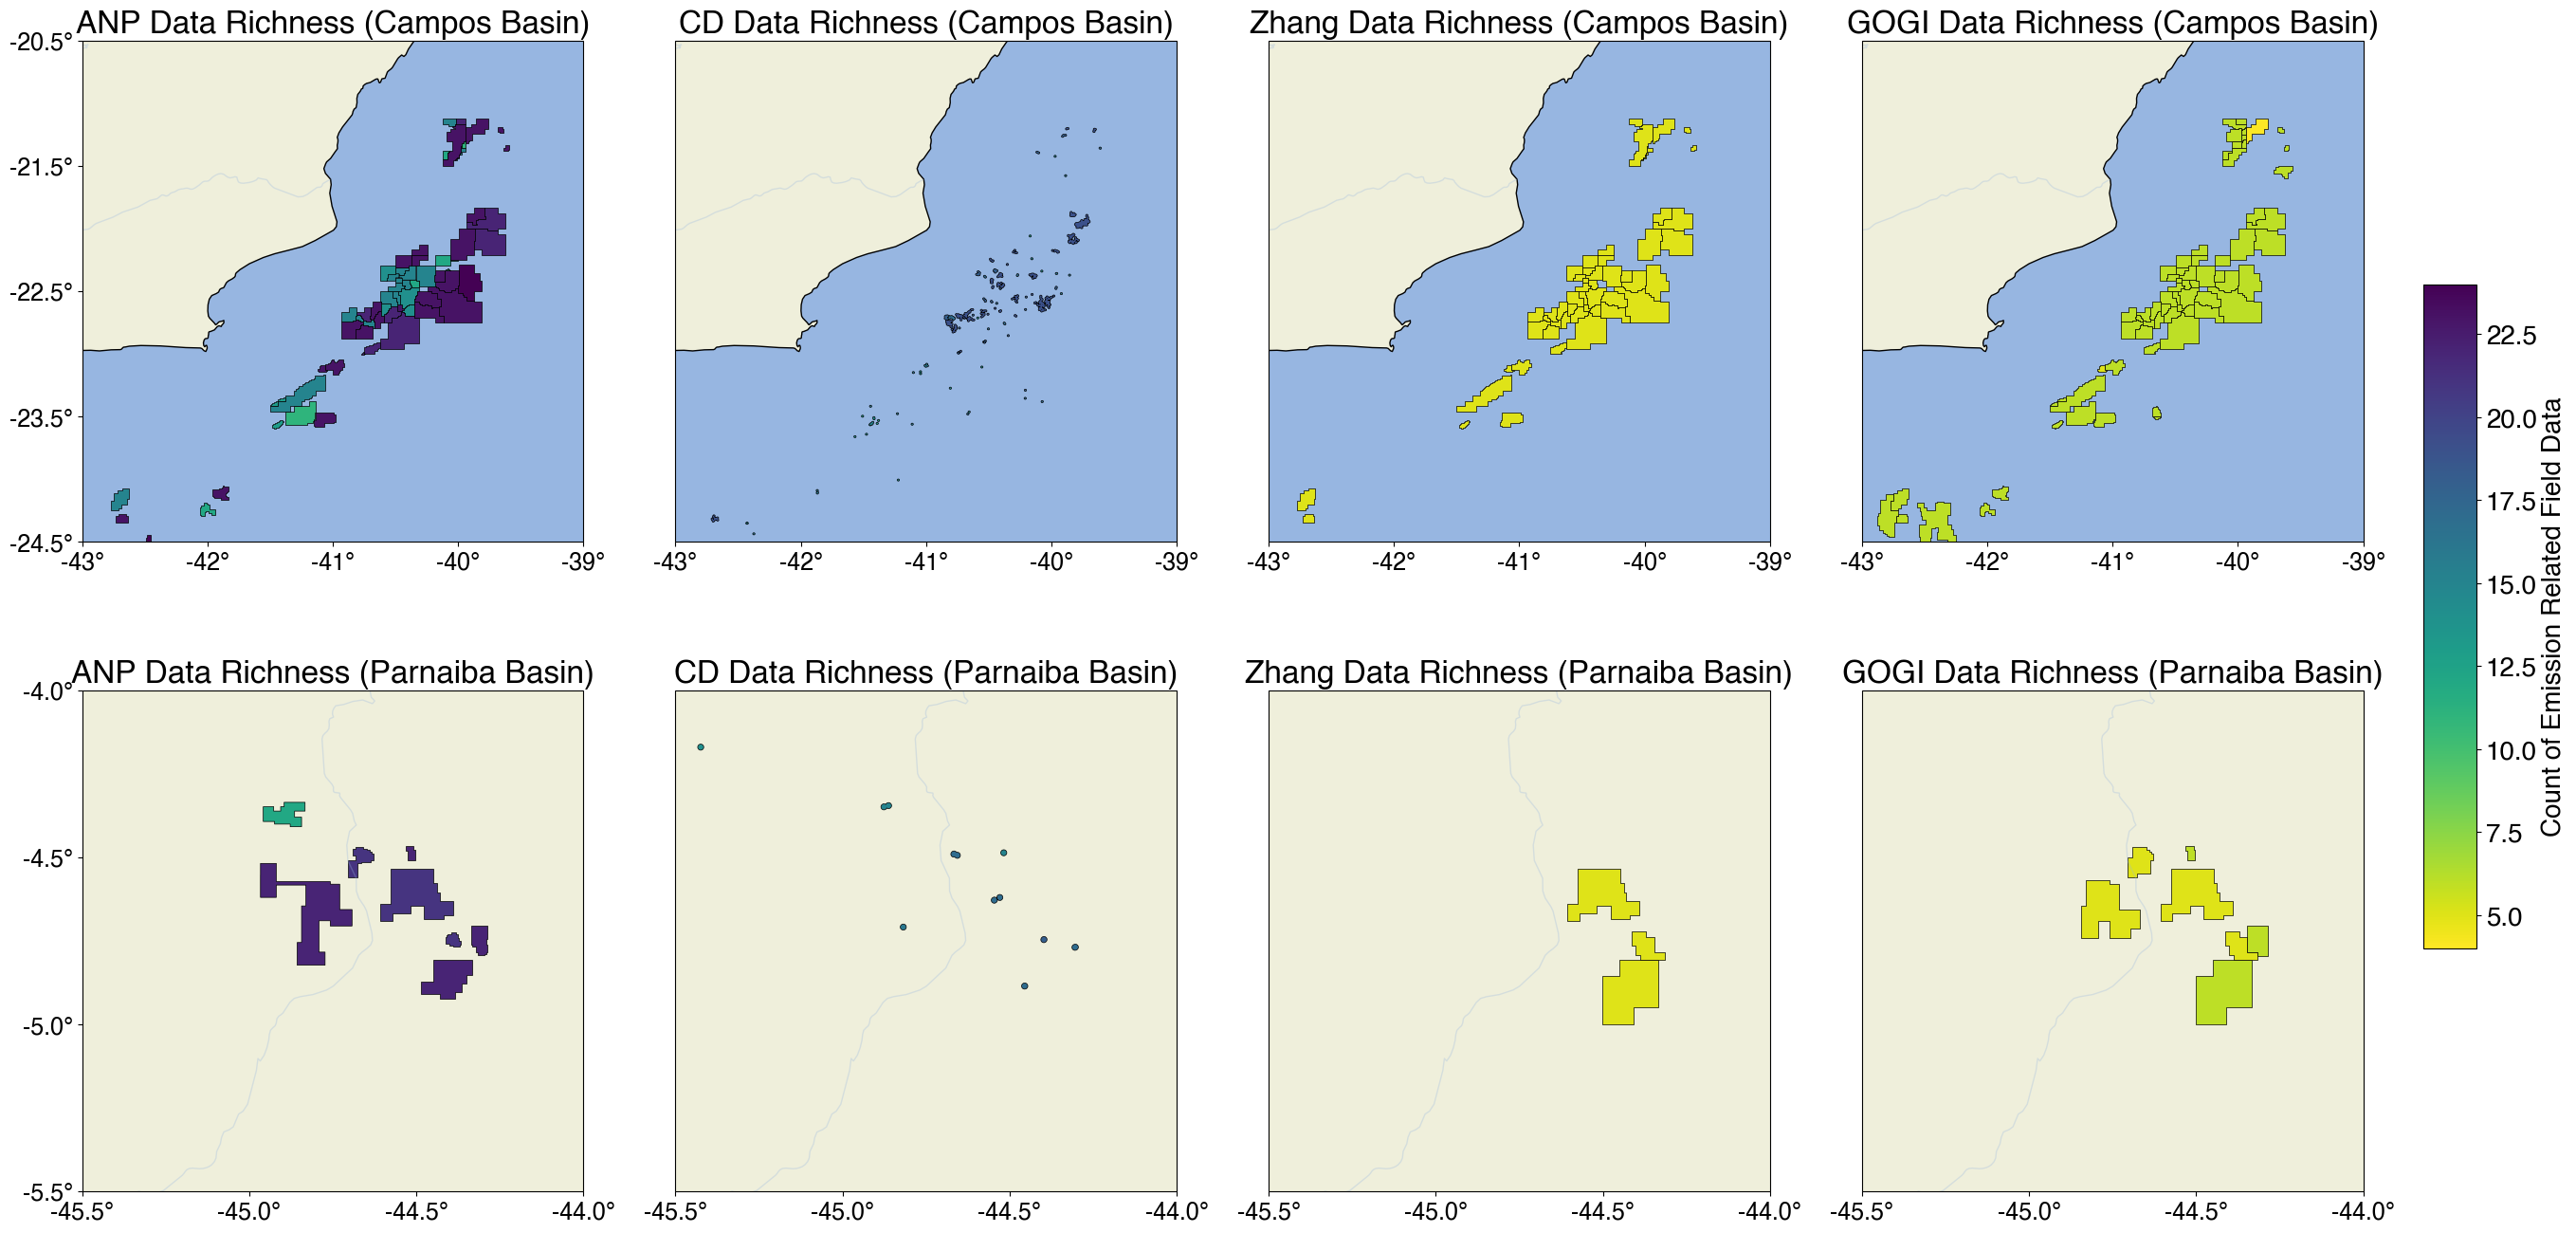

In [4]:
# Load your data from CSV files
# Assuming you've already loaded and processed your data as per the previous code
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 20
# Define vmin and vmax for a consistent color scale
vmin = min(anp_gdf['richness'].min(), wm_gdf['richness'].min(), zhan_gdf['richness'].min(), gogi_gdf['richness'].min())
vmax = max(anp_gdf['richness'].max(), wm_gdf['richness'].max(), zhan_gdf['richness'].max(), gogi_gdf['richness'].max())

# Set the plot extents for both regions
extent_region_1 = [-43, -39, -24.5, -20.5]  # First region (Campos Basin)
extent_region_2 = [-45.5, -44, -5.5, -4.0]  # Second region (Parnaiba Basin)

# Create subplots for the eight maps (2 rows, 4 columns) with equal size
fig, axes = plt.subplots(2, 4, figsize=(28, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Function to plot each map
def plot_region(ax, gdf, extent, title, show_left_label=False, show_top_label=False, lat_ticks=None, lon_ticks=None):
    # Add basemap features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.6)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS, alpha=0.3)

    # Plot the data with light gray boundaries
    gdf.plot(column='richness', cmap='viridis_r', linewidth=0.5, ax=ax, edgecolor='black', vmin=vmin, vmax=vmax, legend=False)
    
    # Set extent and title
    ax.set_extent(extent)
    ax.set_title(title)
    
    # Set latitude ticks on the left edge if required
    if show_left_label and lat_ticks is not None:
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°'))
    else:
        ax.set_yticklabels([])  # Hide y-ticks for interior plots
    
    # Set longitude ticks on the top edge if required
    if show_top_label and lon_ticks is not None:
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°'))
    else:
        ax.set_xticklabels([])  # Hide x-ticks for interior plots
    
    ax.tick_params(labelsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Latitude and longitude ticks for both regions
lat_ticks_region_1 = [-24.5, -23.5, -22.5, -21.5, -20.5]
lon_ticks_region_1 = [-43, -42, -41, -40, -39]

lat_ticks_region_2 = [-5.5, -5, -4.5, -4]
lon_ticks_region_2 = [-45.5, -45, -44.5, -44]

# Plot each map for the first region
plot_region(axes[0, 0], anp_gdf, extent_region_1, 'ANP Data Richness (Campos Basin)', show_left_label=True, show_top_label=True, lat_ticks=lat_ticks_region_1, lon_ticks=lon_ticks_region_1)
plot_region(axes[0, 1], wm_gdf, extent_region_1, 'CD Data Richness (Campos Basin)', show_top_label=True, lon_ticks=lon_ticks_region_1)
plot_region(axes[0, 2], zhan_gdf, extent_region_1, 'Zhang Data Richness (Campos Basin)', show_top_label=True, lon_ticks=lon_ticks_region_1)
plot_region(axes[0, 3], gogi_gdf, extent_region_1, 'GOGI Data Richness (Campos Basin)', show_top_label=True, lon_ticks=lon_ticks_region_1)

# Plot each map for the second region
plot_region(axes[1, 0], anp_gdf, extent_region_2, 'ANP Data Richness (Parnaiba Basin)', show_left_label=True, show_top_label=True, lat_ticks=lat_ticks_region_2, lon_ticks=lon_ticks_region_2)
plot_region(axes[1, 1], wm_gdf, extent_region_2, 'CD Data Richness (Parnaiba Basin)', show_top_label=True, lon_ticks=lon_ticks_region_2)
plot_region(axes[1, 2], zhan_gdf, extent_region_2, 'Zhang Data Richness (Parnaiba Basin)',show_top_label=True, lon_ticks=lon_ticks_region_2)
plot_region(axes[1, 3], gogi_gdf, extent_region_2, 'GOGI Data Richness (Parnaiba Basin)', show_top_label=True,lon_ticks=lon_ticks_region_2)

# Create a colorbar (common legend) with a title
cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Dummy array for the colorbar
cbar = fig.colorbar(sm, cax=cax,label="Count of Emission Related Field Data")

# Adjust layout and show the figure
plt.tight_layout(rect=[0, 0, 0.92, 1])  # Leave space for the colorbar
plt.savefig(f'{DATA_PATH}/br_geodata/plots/data_richness_of_sources.png', format='png', dpi=300)
plt.show()

## Plot for Cumulative Information

/var/folders/8z/nrbsy4n11vvd1rdqlg2hf7lw0000gn/T/ipykernel_67143/4286601967.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Source', y='Data Richness', data=df, palette='coolwarm', label='Data Richness for Source')


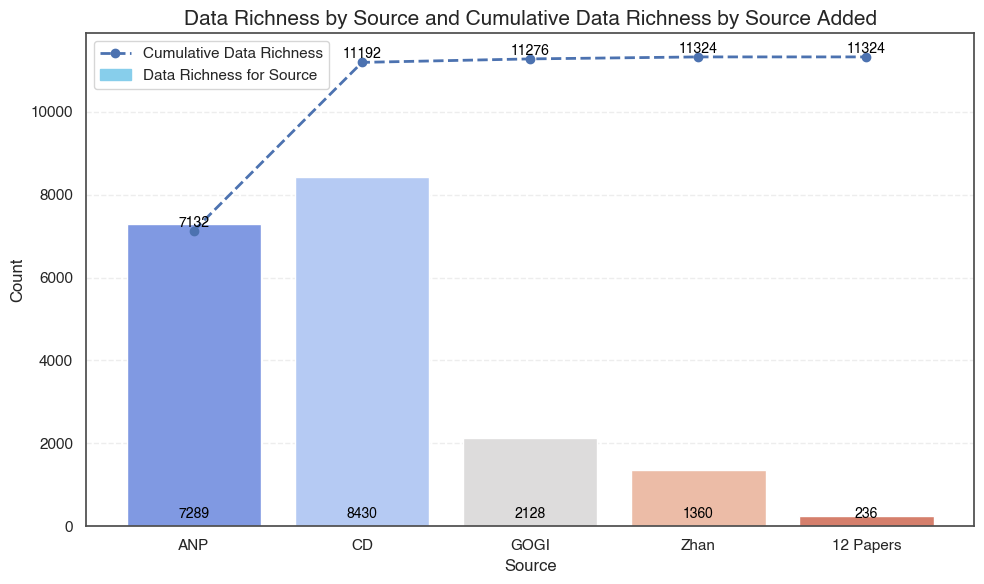

In [5]:
# Load OPGEE columns from JSON
with open(f'{DATA_PATH}/OPGEE_cols.json', 'r') as json_file:
    OPGEE_cols = json.load(json_file)
OPGEE_cols['geometry'] = 'geo'  # Add a column

def count_non_null_cells(df):
    return df.count().sum()

# File paths
base_path = f'{DATA_PATH}/br_geodata'
merged_paths = [f'{base_path}/pyxis_middle_version/merged_pyxis_field_info_table_v{i}.csv' for i in range(1, 6)]
source_info_paths = [f"{base_path}/data_standardization/{src}.csv" for src in [
    'anp', 'wm', 'gogi', 'zhan', 'arma-10-162', 'otc-8879-ms', 'otc-21934-ms',
    'otc-22612-ms', 'otc-30780-ms', 'otc-31900-ms', 'seg-2005-2645',
    'seg-2018-2990024', 'spe-94706-ms', 'spe-140145-ms', 'spe-162323-ms', 'spe-210009-ms'
]]

# Load and filter merged data
merged_data = [pd.read_csv(path).filter(items=OPGEE_cols.keys()) for path in merged_paths]
OPGEE_data_richness = {
    'ANP': count_non_null_cells(merged_data[0]),
    'CD': count_non_null_cells(merged_data[1]),
    'GOGI': count_non_null_cells(merged_data[2]),
    'Zhan': count_non_null_cells(merged_data[3]),
    '12 Papers': count_non_null_cells(merged_data[4])
}

# Load and filter source data
source_data = [pd.read_csv(path).filter(items=OPGEE_cols.keys()) for path in source_info_paths]
cnt = sum(count_non_null_cells(source_data[i]) for i in range(4, len(source_data)))
data_richness = {
    'ANP': count_non_null_cells(source_data[0]),
    'CD': count_non_null_cells(source_data[1]),
    'GOGI': count_non_null_cells(source_data[2]),
    'Zhan': count_non_null_cells(source_data[3]),
    '12 Papers': cnt
}

# Create DataFrame for plotting
df = pd.DataFrame({
    'Source': list(data_richness.keys()),
    'Data Richness': list(data_richness.values()),
    'OPGEE Data Richness': list(OPGEE_data_richness.values())
})

# Plotting with Seaborn and Matplotlib
sns.set(style="whitegrid", rc={"grid.color": ".9", "axes.edgecolor": ".3"})
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Source', y='Data Richness', data=df, palette='coolwarm', label='Data Richness for Source')

# Add data labels for the bar plot
for index, row in df.iterrows():
    plt.text(index, 200, str(row['Data Richness']), color='black', ha="center", fontsize=10)

# Add line plot for cumulative OPGEE data richness
plt.plot(df['Source'], df['OPGEE Data Richness'], marker='o', linewidth=2, linestyle='--', label='Cumulative Data Richness')

# Add data labels for the line plot
for index, row in df.iterrows():
    plt.text(index, row['OPGEE Data Richness'] + 100, str(row['OPGEE Data Richness']), color='black', ha="center", fontsize=10)

# Customize plot
plt.title('Data Richness by Source and Cumulative Data Richness by Source Added', weight='bold', fontsize=15)
plt.xlabel('Source')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add custom legend
custom_legend = [plt.Line2D([0], [0], lw=2, linestyle='--', marker='o', label='Cumulative Data Richness'),
                 mpatches.Patch(label='Data Richness for Source', color='skyblue')]
plt.legend(handles=custom_legend, loc='best')

plt.tight_layout()
plt.savefig(f'{base_path}/plots/Data_richness_plot.png', format='png', dpi=300)
plt.show()

## Plot Field Status Pie Chart

In [6]:
# Load data
wm_fieldinfo = pd.read_excel(f'{DATA_PATH}/br_geodata/wm/wm_field_br.xlsx')
anp_fieldinfo = gpd.read_file(f'{DATA_PATH}/br_geodata/anp/BR_cleaned.shp')

# Load match data
match = pd.read_csv(f'{DATA_PATH}/br_geodata/pyxis_middle_version/pyxis_match_table_v4.csv')
wm = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/wm.csv')
anp = pd.read_csv(f'{DATA_PATH}/br_geodata/data_standardization/anp.csv')

# Create sets of matched and unmatched fields for WM and ANP
wm_match_id = match[match['Source Name'] == 'wm']['Field ID']
anp_match_id = match[match['Source Name'] == 'anp']['Field ID']

# Identify unmatched fields based on whether the field has only one source
unmatch = match.groupby('Pyxis ID').filter(lambda x: len(x) == 1)

wm_unmatch_id = unmatch[unmatch['Source Name'] == 'wm']['Field ID']
anp_unmatch_id = unmatch[unmatch['Source Name'] == 'anp']['Field ID']

# Create field info for matched and unmatched WM and ANP fields
wm_match = wm[wm['Field ID'].isin(wm_match_id)]
anp_match = anp[anp['Field ID'].isin(anp_match_id)]
wm_unmatch = wm[wm['Field ID'].isin(wm_unmatch_id)]
anp_unmatch = anp[anp['Field ID'].isin(anp_unmatch_id)]

wm_fieldinfo_match = wm_fieldinfo[wm_fieldinfo['id_field'].isin(wm_match['Original ID'])]
wm_fieldinfo_unmatch = wm_fieldinfo[wm_fieldinfo['id_field'].isin(wm_unmatch['Original ID'])]
anp_fieldinfo_match = anp_fieldinfo[anp_fieldinfo['Field_ID'].isin(anp_match['Original ID'])]
anp_fieldinfo_unmatch = anp_fieldinfo[anp_fieldinfo['Field_ID'].isin(anp_unmatch['Original ID'])]

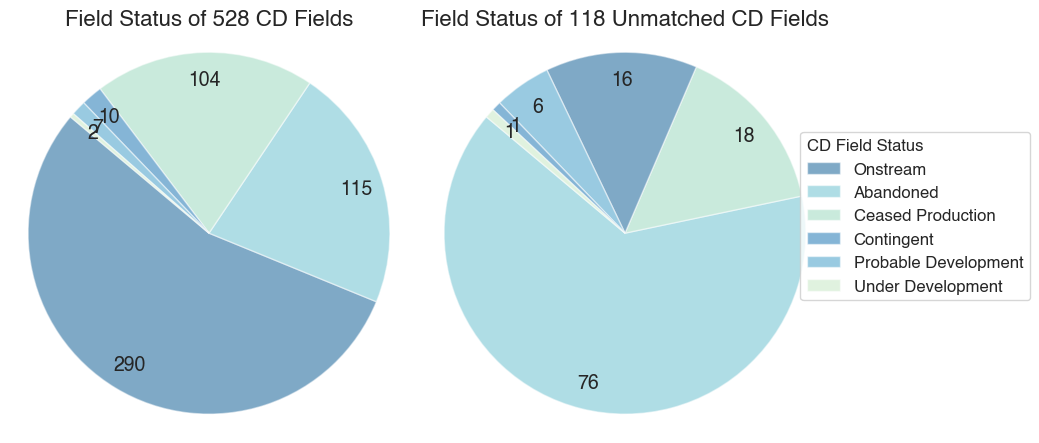

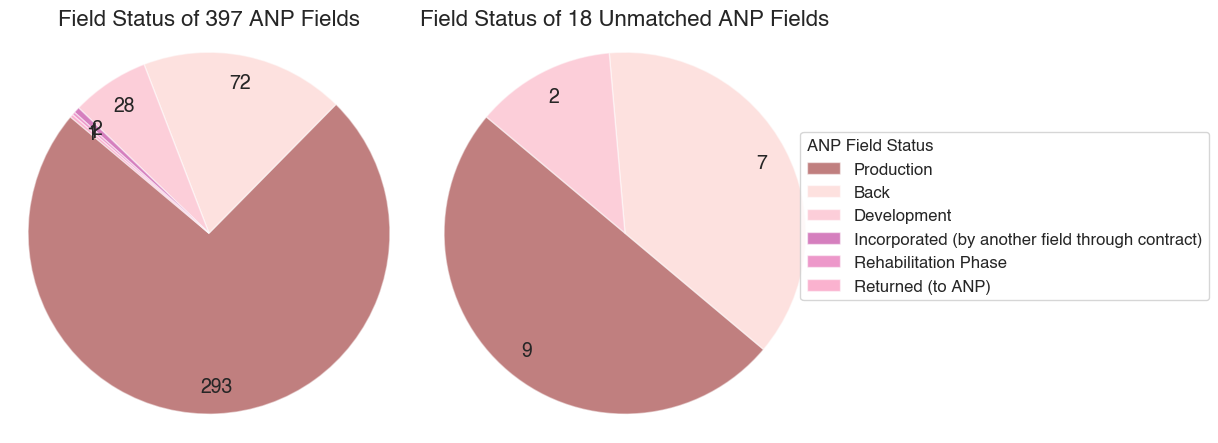

In [7]:
def plot_category_pie_chart(ax, df, column_name, colors=None, title=None):
    # Count occurrences of each category
    no = df.shape[0]
    category_counts = df[column_name].value_counts()
    if colors is None:
        c = sns.color_palette('pastel')[0:len(category_counts)]
    else:
        c = [colors[v] for v in df[column_name].value_counts().keys()]

    # Plot pie chart
    ax.pie(category_counts, autopct=lambda x: '{:.0f}'.format(x * len(df[column_name]) / 100), pctdistance=0.85, startangle=140,
           colors=c,wedgeprops={"alpha": 0.5},textprops={'fontsize': 14})
    
    if title is None:
        ax.set_title(f'Category Distribution for {column_name}', fontsize=16)
    else:
        ax.set_title('Field Status of '+str(no)+' '+title, fontsize=16)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Plot pie charts for unmatched field status investigation

# Plot for WM fields
fig_wm, axes_wm = plt.subplots(1, 2, figsize=(10, 5))

# WM field status
wm_color_label = {}
n = len(wm_fieldinfo_match['field_status'].unique())
colors = sns.color_palette('GnBu', max(n, 1)).as_hex()  # Ensure colors list matches at least one element
sorted_status = sorted([status for status in wm_fieldinfo_match['field_status'].unique() if status is not None and status != 'Onstream'])
statuses = ['Onstream'] + sorted_status
for i, status in enumerate(statuses):
    if i >= len(colors):
        colors.append('#00548f')  # Fallback color if the index exceeds the number of available colors
    if status == 'Onstream':
        colors[i] = '#00548f'  # Darkest color for 'Onstream'
    wm_color_label[status] = colors[i]

# Matched WM fields
plot_category_pie_chart(axes_wm[0], wm_fieldinfo_match, 'field_status', title='CD Fields', colors=wm_color_label)

# Unmatched WM fields
plot_category_pie_chart(axes_wm[1], wm_fieldinfo_unmatch, 'field_status', title='Unmatched CD Fields', colors=wm_color_label)

# Add centralized legend for WM fields, positioned next to the pie charts on the right
fig_wm.legend(wm_color_label.keys(), loc='center left', bbox_to_anchor=(0.8, 0.5), fontsize=12, title='CD Field Status', title_fontsize=12,alignment='left',frameon=True)
plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])
plt.savefig(f'{DATA_PATH}/br_geodata/plots/CD_pie_chart.png', format='png', dpi=300)
plt.show()

# Plot for ANP fields
fig_anp, axes_anp = plt.subplots(1, 2, figsize=(10, 5))

anp_color_label = {}
n = len(anp_fieldinfo_match['Situation'].unique())
colors = sns.color_palette('RdPu', max(n, 1)).as_hex()  # Ensure colors list matches at least one element
sorted_situations = sorted([situation for situation in anp_fieldinfo_match['Situation'].unique() if situation is not None and situation != 'Production'])
situations = ['Production'] + sorted_situations
for i, situation in enumerate(situations):
    if i >= len(colors):
        colors.append('#820000')  # Fallback color if the index exceeds the number of available colors
    if situation == 'Production':
        colors[i] = '#820000'  # Darkest color for 'Production'
    anp_color_label[situation] = colors[i]

# Matched ANP fields
plot_category_pie_chart(axes_anp[0], anp_fieldinfo_match, 'Situation', title='ANP Fields', colors=anp_color_label)

# Unmatched ANP fields
plot_category_pie_chart(axes_anp[1], anp_fieldinfo_unmatch, 'Situation', title='Unmatched ANP Fields', colors=anp_color_label)

# Add centralized legend for ANP fields, positioned next to the pie charts on the right
fig_anp.legend(anp_color_label.keys(), loc='center left', bbox_to_anchor=(0.8, 0.5), fontsize=12, title='ANP Field Status',alignment='left',title_fontsize=12,frameon=True)
plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])
plt.savefig(f'{DATA_PATH}/br_geodata/plots/ANP_pie_chart.png', format='png', dpi=300)
plt.show()

## Comparison between Data Source Coverage

In [11]:
global_zhan = gpd.read_file(f'{DATA_PATH}/zhan_field/zhan_global_field_shape.json', crs='4326')
global_wm = gpd.read_file(f'{DATA_PATH}/wm_well/global_wm_fields.json', crs='4326')
global_ogim = gpd.read_file(f'{DATA_PATH}/OGIM_field/OGIM_global_fields.geojson', crs='4326')
global_gogi = gpd.read_file(f'{DATA_PATH}/GOGI_field/Fields.shp', crs='4326')
global_wm_field = pd.read_excel('/Users/yaqifan/Documents/Github/OPGEE-GlobalGas/data/wm_2021/WM_LENS_upstream_weekly-field_summary_accessed 10052022_SEED.xlsx')


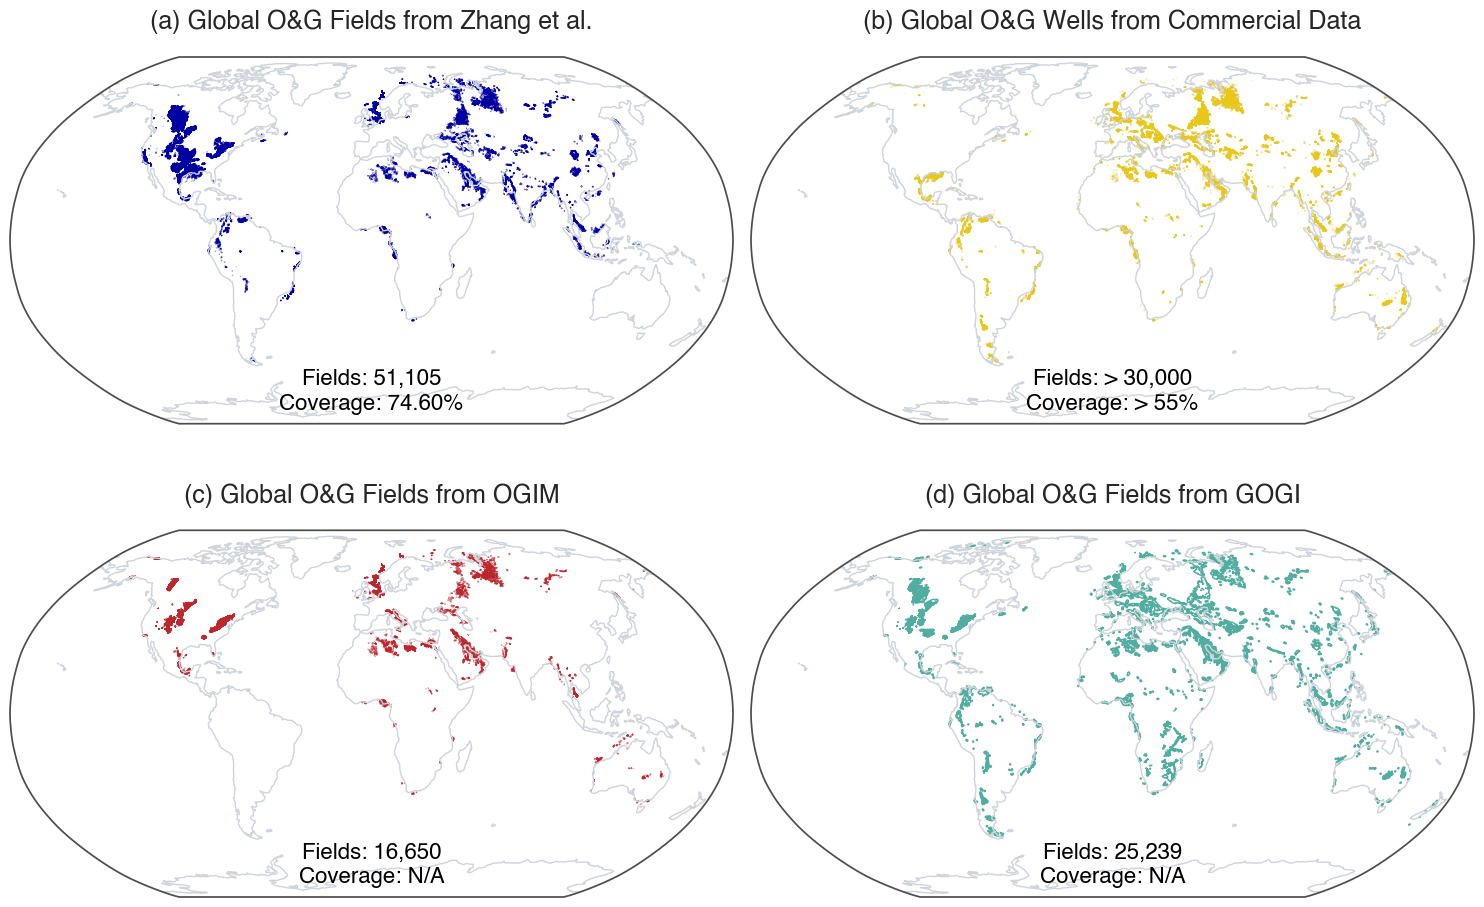

In [ ]:
# Calculate coverage
global_2021 = 88.45e6  # Global production in 2021
zhan_coverage = global_zhan['SUM_OIL_PR'].sum() / global_2021
list_id = global_wm['id_field_a'].to_list()
wm_coverage = global_wm_field[global_wm_field['id_field'].isin(list_id)]['f_production_prev_oil__kbd'].sum() * 1e3 / global_2021

# Field counts
zhan_fields = 51105
wm_fields = 30475
ogim_fields = 16650
gogi_fields = 25239

# Production fractions
zhan_fraction = zhan_coverage * 100  # Convert to percentage
wm_fraction = wm_coverage * 100

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson()})

# Set up maps and titles
titles = [
    '(a) Global O&G Fields from Zhang et al.',
    '(b) Global O&G Wells from Commercial Data',
    '(c) Global O&G Fields from OGIM',
    '(d) Global O&G Fields from GOGI'
]

field_counts = [
    f'Fields: {zhan_fields:,}\nCoverage: {zhan_fraction:.2f}%',
    f'Fields: > 30,000\nCoverage: > 55%',
    f'Fields: {ogim_fields:,}\nCoverage: N/A',
    f'Fields: {gogi_fields:,}\nCoverage: N/A'
]

# Loop through axes and set up the map
for i, ax in enumerate(axs.flat):
    ax.coastlines(color=(206/255, 212/255, 219/255))
    ax.set_global()
    ax.set_title(titles[i], fontsize=18, pad=20)
    # Add field count and coverage inside each subplot
    ax.text(0.5, 0.15, field_counts[i], fontsize=16, color='black', ha='center', va='top', transform=ax.transAxes)

# Plot datasets on each subplot
global_zhan.to_crs(ccrs.Robinson().proj4_init).plot(ax=axs[0, 0], edgecolor='#0000a2', facecolor='none')
global_wm.to_crs(ccrs.Robinson().proj4_init).plot(ax=axs[0, 1], edgecolor='#e9c716', facecolor='none')
global_ogim.to_crs(ccrs.Robinson().proj4_init).plot(ax=axs[1, 0], edgecolor='#bc272d', facecolor='none')
global_gogi.to_crs(ccrs.Robinson().proj4_init).plot(ax=axs[1, 1], edgecolor='#50ad9f', facecolor='none')

# Adjust layout and save
plt.tight_layout()
plt.savefig('../data/br_geodata/plots/Comparison_between_data_coverage.png', format='png', dpi=300)
plt.show()

## CI Analysis Plot

In [4]:
excel_path_with_wm = f'{DATA_PATH}/OPGEE_model/OPGEE_3.0c_BETA_BR_withwm.xlsm'
excel_path_without_wm = f'{DATA_PATH}/OPGEE_model/OPGEE_3.0c_BETA_BR_wowm.xlsm'
scatter_plot_output_path = f'{DATA_PATH}/br_geodata/plots/Scatter_CI_Comparison_with_without_wm.svg'
num_fields_with_wm = 279  # Replace with the actual number of fields with WM
num_fields_without_wm = 277  # Replace with the actual number of fields without WM

results_with_wm = load_opgee_results(excel_path_with_wm, num_fields_with_wm)
results_without_wm = load_opgee_results(excel_path_without_wm, num_fields_without_wm)

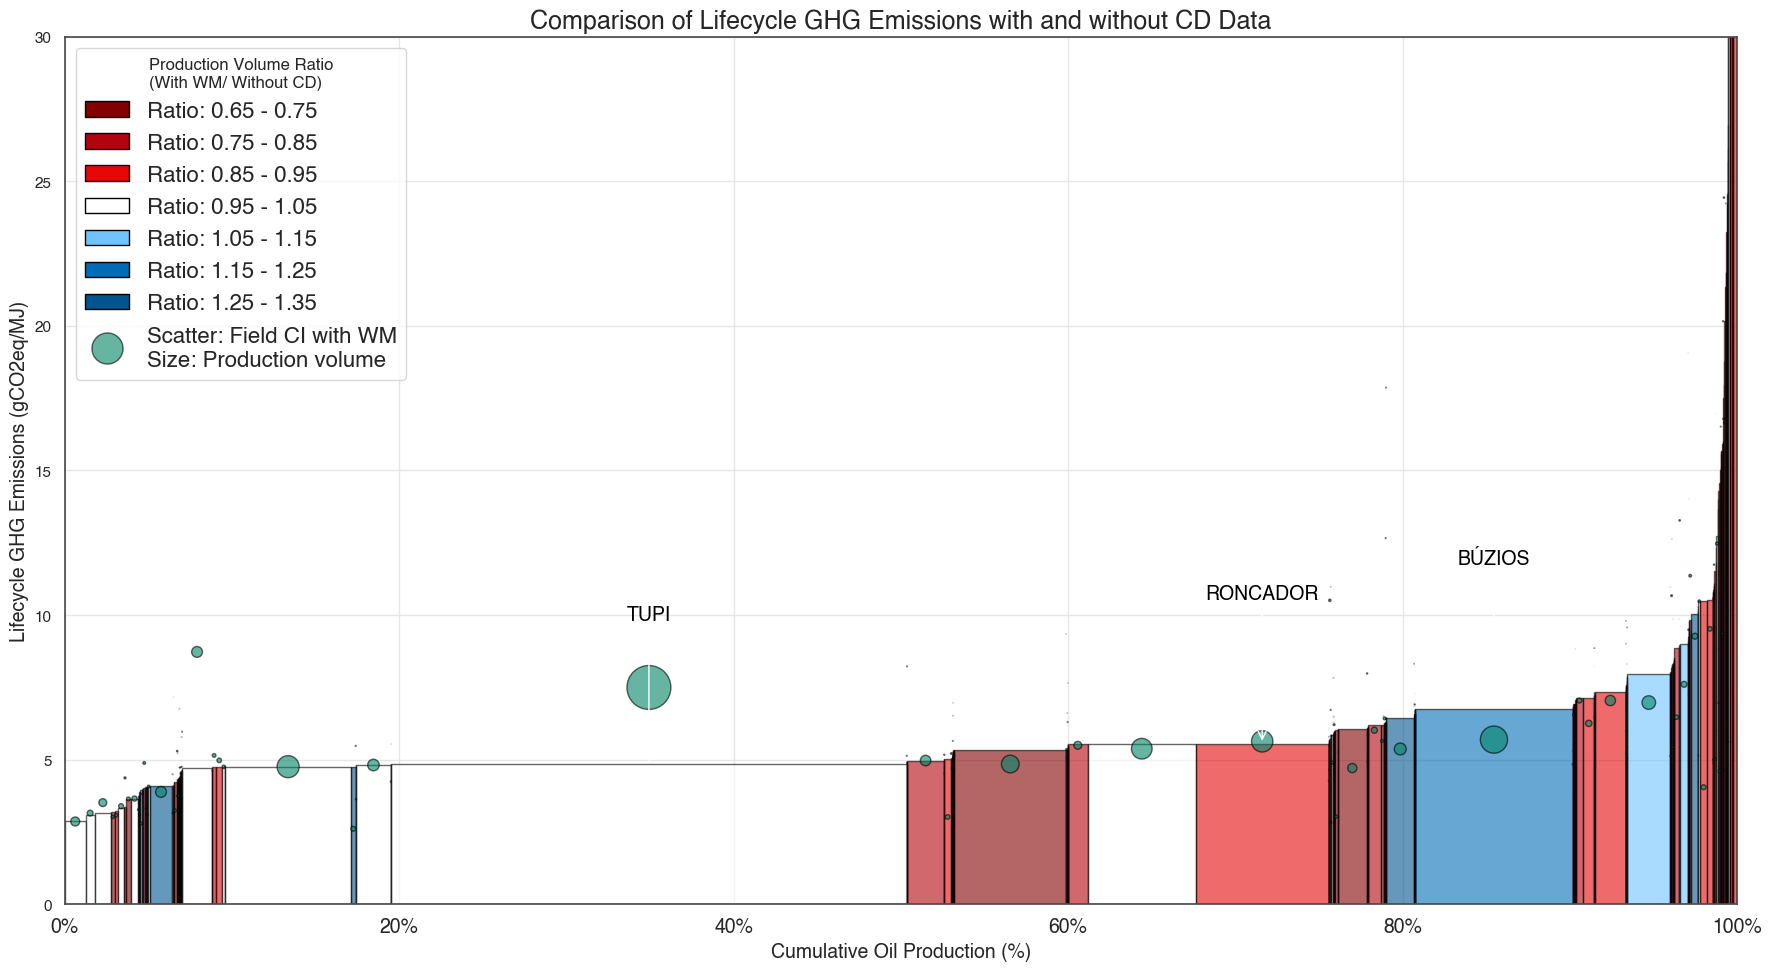

In [53]:
plt.rcParams['font.size'] = 16
# Merge the datasets on Field name
merged_results = pd.merge(results_with_wm, results_without_wm, on='Field name', suffixes=('_with_wm', '_without_wm'))

# Sort the merged results by CI without WM data in ascending order
merged_results = merged_results.sort_values(by='Lifecycle GHG Emissions_without_wm')

# Calculate cumulative production using width and cumulative_x approach
merged_results['width'] = merged_results['Oil Production_without_wm'] / merged_results['Oil Production_without_wm'].sum()
merged_results['cumulative_x'] = merged_results['width'].cumsum() - merged_results['width']

# Calculate the oil production volume change ratio
merged_results['production_change_ratio'] = merged_results['Oil Production_with_wm'] / merged_results['Oil Production_without_wm']

# Set up the cumulative plot
fig, ax = plt.subplots(figsize=(18, 10))

# Define color groups for different ranges of production change ratios
color_bins = [0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35]
colors = ['#820000', '#B1040E', '#E50808', '#ffffff', '#6FC3FF', '#006CB8', '#00548f']

# Plot the CI without WM data as bars with color indicating production volume change ratio
for i, row in merged_results.iterrows():
    ratio = row['production_change_ratio']
    for j in range(len(color_bins) - 1):
        if color_bins[j] <= ratio < color_bins[j + 1]:
            color = colors[j]
            break
        elif ratio >= color_bins[-1]:
            color = colors[-1]
    ax.bar(row['cumulative_x'], row['Lifecycle GHG Emissions_without_wm'],
           width=row['width'], align='edge',
           color=color, edgecolor='black', alpha=0.6)

# Plot the CI with WM data as scatter points to indicate changes
scatter = ax.scatter(merged_results['cumulative_x'] + merged_results['width'] / 2, merged_results['Lifecycle GHG Emissions_with_wm'],
           s=merged_results['Oil Production_with_wm'] / merged_results['Oil Production_with_wm'].max() * 1000,
           color='#008566', marker='o', edgecolor='black', alpha=0.6)

# Labeling
ax.set_xlabel('Cumulative Oil Production (%)', fontsize=14)
ax.set_ylim(0, 30)
ax.set_ylabel('Lifecycle GHG Emissions (gCO2eq/MJ)', fontsize=14)
ax.set_title('Comparison of Lifecycle GHG Emissions with and without CD Data', fontsize=18)

# Add legend for scatter and color bins
handles, labels = ax.get_legend_handles_labels()
# Add color bin legend
color_bin_labels = [
    '0.65 - 0.75',
    '0.75 - 0.85',
    '0.85 - 0.95',
    '0.95 - 1.05',
    '1.05 - 1.15',
    '1.15 - 1.25',
    '1.25 - 1.35'
]
for color, label in zip(colors, color_bin_labels):
    handles.extend([patches.Patch(facecolor=color, edgecolor='black',label=f'Ratio: {label}')])
    labels.extend([f'Ratio: {label}'])
# Add scatter legend after color bins
scatter_legend = plt.Line2D([0], [0], marker='o', color='white', markeredgecolor='black',label='Oil Production Volume', 
                             markerfacecolor='#008566', markersize=np.sqrt(2000) / 2, alpha=0.6)
handles.append(scatter_legend)
labels.append('Scatter: Field CI with WM\nSize: Production volume')

# Add scatter legend after color bins

ax.legend(handles=handles, labels=labels, title = 'Production Volume Ratio\n(With WM/ Without CD)',fontsize=16, loc='upper left', frameon=True)

# Highlight the top three fields by impact (oil production * CI) without WM data
merged_results['Impact_without_wm'] = merged_results['Oil Production_without_wm'] * merged_results['Lifecycle GHG Emissions_without_wm']
top_3_impact = merged_results.nlargest(3, 'Impact_without_wm')
for i, row in top_3_impact.iterrows():
    ax.annotate(row['Field name'], xy=(row['cumulative_x'] + row['width'] / 2, row['Lifecycle GHG Emissions_without_wm']),
                xytext=(row['cumulative_x'] + row['width'] / 2, row['Lifecycle GHG Emissions_without_wm'] + 5),
                arrowprops=dict(facecolor='black', arrowstyle="->"), ha='center', fontsize=14, color='black')

# Customize x-axis to show cumulative oil production percentage
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_xticklabels([f'{int(x * 100)}%' for x in np.linspace(0, 1, 6)], fontsize=14)
plt.xlim(0, 1)
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

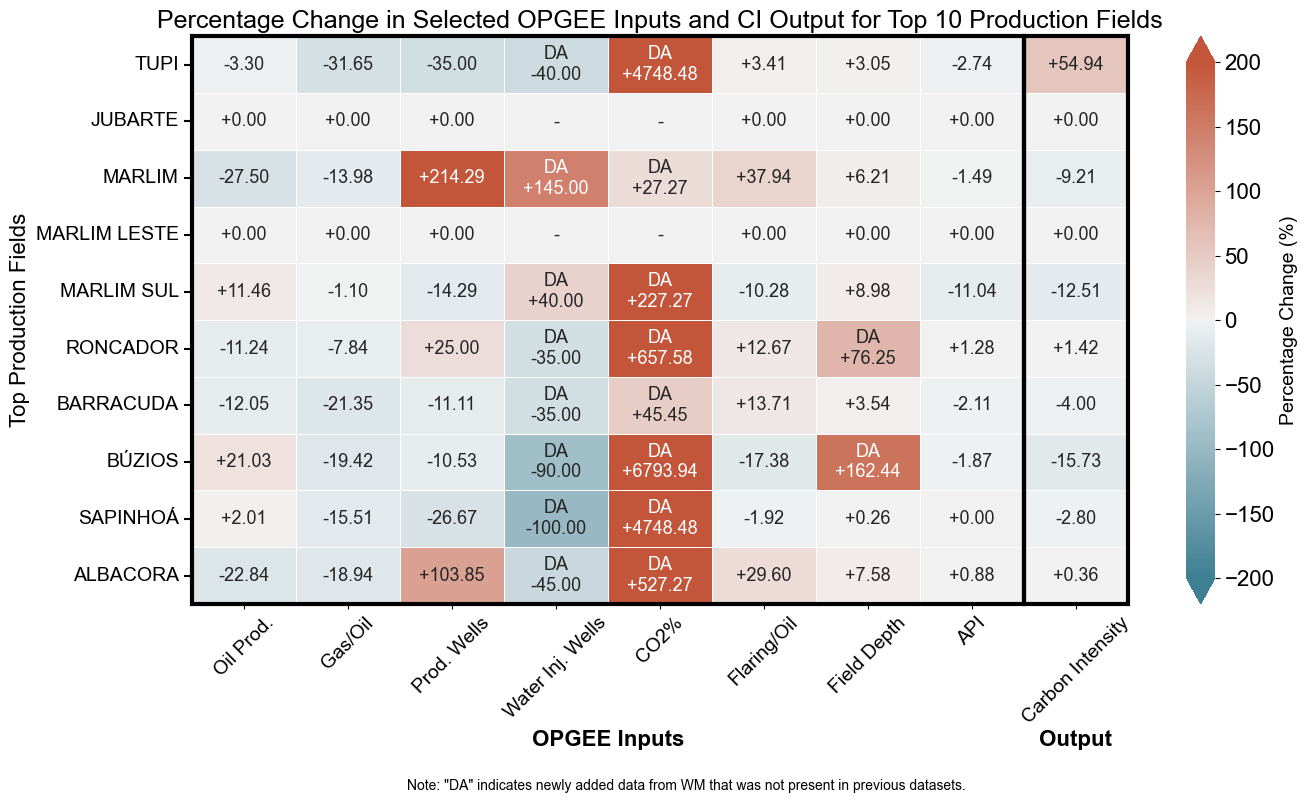

In [5]:
plt.rcParams['font.size'] = 16
def load_data(filepath_wm, filepath_without_wm):
    # Load the CSV data for both with and without WM versions
    data_wm = pd.read_csv(filepath_wm)
    data_without_wm = pd.read_csv(filepath_without_wm)
    return data_wm, data_without_wm

def prepare_top_fields(data_without_wm, num_fields=10):
    # Extract the top production fields based on oil production from the without WM data
    top_fields = data_without_wm.sort_values(by='Oil production volume', ascending=False).head(num_fields)
    return top_fields['Field name'].tolist()

def prepare_value_changes(data_wm, data_without_wm, top_fields, columns_to_compare, results_with_wm, results_without_wm, default_values):
    # Filter data for the top fields
    data_wm_top = data_wm[data_wm['Field name'].isin(top_fields)]
    data_without_wm_top = data_without_wm[data_without_wm['Field name'].isin(top_fields)]
    
    # Merge the dataframes to compare columns
    merged_data = pd.merge(data_wm_top, data_without_wm_top, on='Field name', suffixes=('_with_wm', '_without_wm'))
    
    # Calculate the percentage change and value differences for selected columns
    changes_pc = {'Field name': merged_data['Field name']}
    changes_label = {'Field name': merged_data['Field name']}
    
    for column in columns_to_compare:
        column_with_wm = merged_data[f'{column}_with_wm']
        column_without_wm = merged_data[f'{column}_without_wm']
        
        # Calculate value difference and handle label indications before filling NaN values
        changes_label[column] = ((column_with_wm - column_without_wm) / column_without_wm) * 100
        changes_label[column] = changes_label[column].where(~(column_with_wm.isna() & column_without_wm.isna()), other='-')
        changes_label[column] = changes_label[column].where(~(column_without_wm.isna() & ~column_with_wm.isna()), other='Data Added')
        
        # Handle NaN values in the without WM data for percentage change calculation
        column_without_wm.fillna(default_values.get(column, 0), inplace=True)
        column_with_wm.fillna(default_values.get(column, 0), inplace=True)
        
        # Calculate percentage change and add plus sign for positive values
        changes_pc[column] = ((column_with_wm - column_without_wm) / column_without_wm) * 100
        changes_pc[column] = changes_pc[column].apply(lambda x: f'{x:+.2f}' if pd.notna(x) else '-')
        
        # Update changes_label with percentage representation for numeric values
        changes_label_list = []
        for idx, value in changes_label[column].items():
            if value == 'Data Added':
                changes_label_list.append(f'DA\n{changes_pc[column].iloc[idx]}')
            elif isinstance(value, (int, float)) and pd.notna(value):
                changes_label_list.append(f'{value:+.2f}')
            else:
                changes_label_list.append(value)
        changes_label[column] = changes_label_list

    # Add the CI result change using the results_with_wm and results_without_wm dataframes
    results_merged = pd.merge(results_with_wm, results_without_wm, on='Field name', suffixes=('_with_wm', '_without_wm'))
    ci_change_pc = ((results_merged['Lifecycle GHG Emissions_with_wm'] - results_merged['Lifecycle GHG Emissions_without_wm']) / results_merged['Lifecycle GHG Emissions_without_wm']) * 100
    ci_change_label = ((results_merged['Lifecycle GHG Emissions_with_wm'] - results_merged['Lifecycle GHG Emissions_without_wm']) / results_merged['Lifecycle GHG Emissions_without_wm']) * 100
    
    # Handle CI changes for top fields
    ci_change_top_fields_pc = ci_change_pc[results_merged['Field name'].isin(top_fields)].reset_index(drop=True)
    ci_change_top_fields_label = ci_change_label[results_merged['Field name'].isin(top_fields)].reset_index(drop=True)
    
    changes_pc['CI_change'] = ci_change_top_fields_pc.apply(lambda x: f'{x:+.2f}' if pd.notna(x) else 'No Data').values
    changes_label['CI_change'] = ci_change_top_fields_label.apply(lambda x: f'{x:+.2f}' if pd.notna(x) else ('No Data' if pd.isna(x) else 'Data Added')).values
    
    # Create DataFrames for the heatmap
    changes_df_pc = pd.DataFrame(changes_pc).set_index('Field name')
    changes_df_label = pd.DataFrame(changes_label).set_index('Field name')
    return changes_df_pc, changes_df_label

def plot_heatmap(changes_df_pc, changes_df_label, output_path, short_labels):
    # Convert the percentage changes to numeric values for plotting
    changes_df_pc_numeric = changes_df_pc.apply(pd.to_numeric, errors='coerce')
    
    # Plotting the heatmap with seaborn
    plt.figure(figsize=(14, 8))  # Increase the width to separate CI column
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    ax = sns.heatmap(changes_df_pc_numeric, annot=changes_df_label, cmap=cmap, center=0, fmt="", linewidths=.5,cbar_kws={'label': 'Percentage Change (%)', 'extend': 'both'},annot_kws={'size': 13}, vmin=-200, vmax=200)
    # modify colorbar
    cbar = ax.collections[0].colorbar
    # Set label font size
    cbar.set_label('Percentage Change (%)', size=14)
    # Add a thick black box around the CI column
    ci_column_index = len(short_labels) - 1
    for _, spine in ax.spines.items():
        spine.set_visible(False)
    ax.add_patch(plt.Rectangle((ci_column_index, 0), 1, changes_df_pc_numeric.shape[0], fill=False, edgecolor='black', lw=3, clip_on=False))
    
    # Add a thick black box around all input columns
    ax.add_patch(plt.Rectangle((0, 0), ci_column_index, changes_df_pc_numeric.shape[0], fill=False, edgecolor='black', lw=3, clip_on=False))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)  # Visible + sized
    ax.tick_params(axis='y', labelsize=14,length=6,width=1.5)
    # Highlight the CI column label as red
    plt.xticks(ticks=np.arange(len(short_labels)) + 0.5, labels=[label for i, label in enumerate(short_labels)], rotation=45, ha='center', fontsize=14)  # Center labels over each cell and make them horizontal
    # Add input and output annotations
    plt.text(ci_column_index - 4, changes_df_pc_numeric.shape[0] + 2.5, 'OPGEE Inputs', fontweight='bold', fontsize=16, ha='center')
    plt.text(ci_column_index + 0.5, changes_df_pc_numeric.shape[0] + 2.5, 'Output', fontsize=16, fontweight='bold', ha='center')
    
    plt.title('Percentage Change in Selected OPGEE Inputs and CI Output for Top 10 Production Fields',fontsize=18)
    plt.ylabel('Top Production Fields',fontsize=16)
    plt.tight_layout()
    plt.figtext(0.5, -0.005, 'Note: "DA" indicates newly added data from WM that was not present in previous datasets.', wrap=True, horizontalalignment='center', fontsize=10)
    plt.savefig(output_path, format='png', dpi=300)
    plt.show()


# Filepaths
filepath_wm = f'{DATA_PATH}/br_geodata/merged_pyxis_field_info_with_flare_withwm.csv'
filepath_without_wm = f'{DATA_PATH}/br_geodata/merged_pyxis_field_info_with_flare_wowm.csv'
output_path = f'{DATA_PATH}/br_geodata/plots/Top_Fields_OPGEE_Heatmap.png'

# Load data
data_wm, data_without_wm = load_data(filepath_wm, filepath_without_wm)

# Define the columns to compare and their default values
columns_to_compare = ['Oil production volume','Gas-to-oil ratio (GOR)','Number of producing wells','Number of producing wells', 'Number of water injecting wells','CO2','Flaring-to-oil ratio', 'Field depth','API gravity (oil at standard pressure and temperature, or "dead oil")']
default_values = {
    'Oil production volume': 2098,
    'Gas-to-oil ratio (GOR)': 2429.3,
    'Number of producing wells': 24,
    'Number of water injecting wells': 20,
    'CO2': 0.33,
    'Flaring-to-oil ratio': 143,
    'Field depth': 7240,
    'API gravity (oil at standard pressure and temperature, or "dead oil")':32.8
}

# Shortened labels for the OPGEE Parameters
short_labels = ['Oil Prod.', 'Gas/Oil', 'Prod. Wells', 'Water Inj. Wells', 'CO2%', 'Flaring/Oil', 'Field Depth', 'API','Carbon Intensity']

# Load results for without WM to find the top fields
top_fields = prepare_top_fields(data_without_wm)

# Prepare the value changes for the heatmap
changes_df_pc, changes_df_label = prepare_value_changes(data_wm, data_without_wm, top_fields, columns_to_compare, results_with_wm, results_without_wm, default_values)

# Plot the heatmap
plot_heatmap(changes_df_pc, changes_df_label, output_path, short_labels)


In [75]:
desc_stats = pd.DataFrame({
    'Statistic': ['Mean CI', 'Median CI', 'Standard Deviation', 'Minimum CI', 'Maximum CI', 'Number of Fields'],
    'With WM Data': [
        merged_results['Lifecycle GHG Emissions_with_wm'].mean(),
        merged_results['Lifecycle GHG Emissions_with_wm'].median(),
        merged_results['Lifecycle GHG Emissions_with_wm'].std(),
        merged_results['Lifecycle GHG Emissions_with_wm'].min(),
        merged_results['Lifecycle GHG Emissions_with_wm'].max(),
        merged_results['Lifecycle GHG Emissions_with_wm'].count()
    ],
    'Without WM Data': [
        merged_results['Lifecycle GHG Emissions_without_wm'].mean(),
        merged_results['Lifecycle GHG Emissions_without_wm'].median(),
        merged_results['Lifecycle GHG Emissions_without_wm'].std(),
        merged_results['Lifecycle GHG Emissions_without_wm'].min(),
        merged_results['Lifecycle GHG Emissions_without_wm'].max(),
        merged_results['Lifecycle GHG Emissions_without_wm'].count()
    ],
    'Difference (With - Without)': [
        merged_results['Lifecycle GHG Emissions_with_wm'].mean() - merged_results['Lifecycle GHG Emissions_without_wm'].mean(),
        merged_results['Lifecycle GHG Emissions_with_wm'].median() - merged_results['Lifecycle GHG Emissions_without_wm'].median(),
        '-',
        '-',
        '-',
        '-'
    ]
})

print(desc_stats)

            Statistic  With WM Data  Without WM Data  \
0             Mean CI      8.581796         8.794259   
1           Median CI      5.596621         6.179516   
2  Standard Deviation     11.049186         7.623616   
3          Minimum CI      2.606775         2.859714   
4          Maximum CI    132.502593        53.136275   
5    Number of Fields    261.000000       261.000000   

  Difference (With - Without)  
0                   -0.212463  
1                   -0.582895  
2                           -  
3                           -  
4                           -  
5                           -  


In [76]:
# Assuming 'merged_results' DataFrame has already been prepared
# Calculate differences
differences = merged_results['Lifecycle GHG Emissions_with_wm'] - merged_results['Lifecycle GHG Emissions_without_wm']

# Perform Wilcoxon signed-rank test
w_stat, p_value = wilcoxon(merged_results['Lifecycle GHG Emissions_with_wm'], merged_results['Lifecycle GHG Emissions_without_wm'])

# Calculate the number of positive, negative, and tied differences
positive_count = (differences > 0).sum()
negative_count = (differences < 0).sum()
tie_count = (differences == 0).sum()

# Calculate the z-value approximation for Wilcoxon signed-rank test
# Assuming large sample size for z-value calculation
n = len(differences[differences != 0])  # Number of non-zero differences
mean_rank_sum = n * (n + 1) / 4
std_dev_rank_sum = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
z_value = (w_stat - mean_rank_sum) / std_dev_rank_sum if std_dev_rank_sum != 0 else np.nan

# Significance level
alpha = 0.05

# Interpret the Wilcoxon signed-rank test result
if p_value < alpha:
    conclusion = "There is a statistically significant difference in CI between fields with and without WM data."
else:
    conclusion = "There is no statistically significant difference in CI between fields with and without WM data."

# Display all information
print(f"Wilcoxon Signed-Rank Test Results:")
print(f"Positive Differences (+): {positive_count}")
print(f"Negative Differences (-): {negative_count}")
print(f"Tied Differences (=): {tie_count}")
print(f"Wilcoxon Statistic (W): {w_stat}")
print(f"Z-value: {z_value:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Conclusion: {conclusion}")


Wilcoxon Signed-Rank Test Results:
Positive Differences (+): 87
Negative Differences (-): 156
Tied Differences (=): 18
Wilcoxon Statistic (W): 10666.0
Z-value: -3.7899
p-value: 0.0002
Conclusion: There is a statistically significant difference in CI between fields with and without WM data.


## Satellite data vs government report data

In [77]:
# Load satellite flare data
def load_satellite_data(filepath):
    satellite_data = pd.read_csv(filepath)
    satellite_data['Field name'] = satellite_data['Field name'].str.lower()
    # Convert satellite flare volume from billion cubic meters (BCM) to cubic feet
    satellite_data['flare_volume'] = satellite_data['flare_volume'] * 1000000000
    return satellite_data

# Load ANP reported data
def load_anp_data(filepath):
    anp_data = pd.read_excel(filepath)
    # Convert the necessary columns to lowercase
    anp_data['Field'] = anp_data['Field'].str.lower()
    anp_data['Period'] = pd.to_datetime(anp_data['Period'], format='%Y-%m')
    anp_data['month'] = anp_data['Period'].dt.month
    # Convert ANP reported flare volume from thousand cubic meters to cubic feet and sum for each month
    days_in_month = anp_data['Period'].dt.days_in_month
    anp_data['flare_volume'] = anp_data['Gas Flaring (Mm³/day)'] * days_in_month * 1000
    return anp_data[['Field', 'month', 'flare_volume']]

satellite_data = load_satellite_data(f'{DATA_PATH}/br_geodata/flare_2021/pyxis_field_monthly_flare_match_2021.csv')

# Load ANP data
anp_data = load_anp_data(f'{DATA_PATH}/br_geodata/anp/raw/translated_data_for_field_movement_2021.xlsx')

Number of Observations: 451


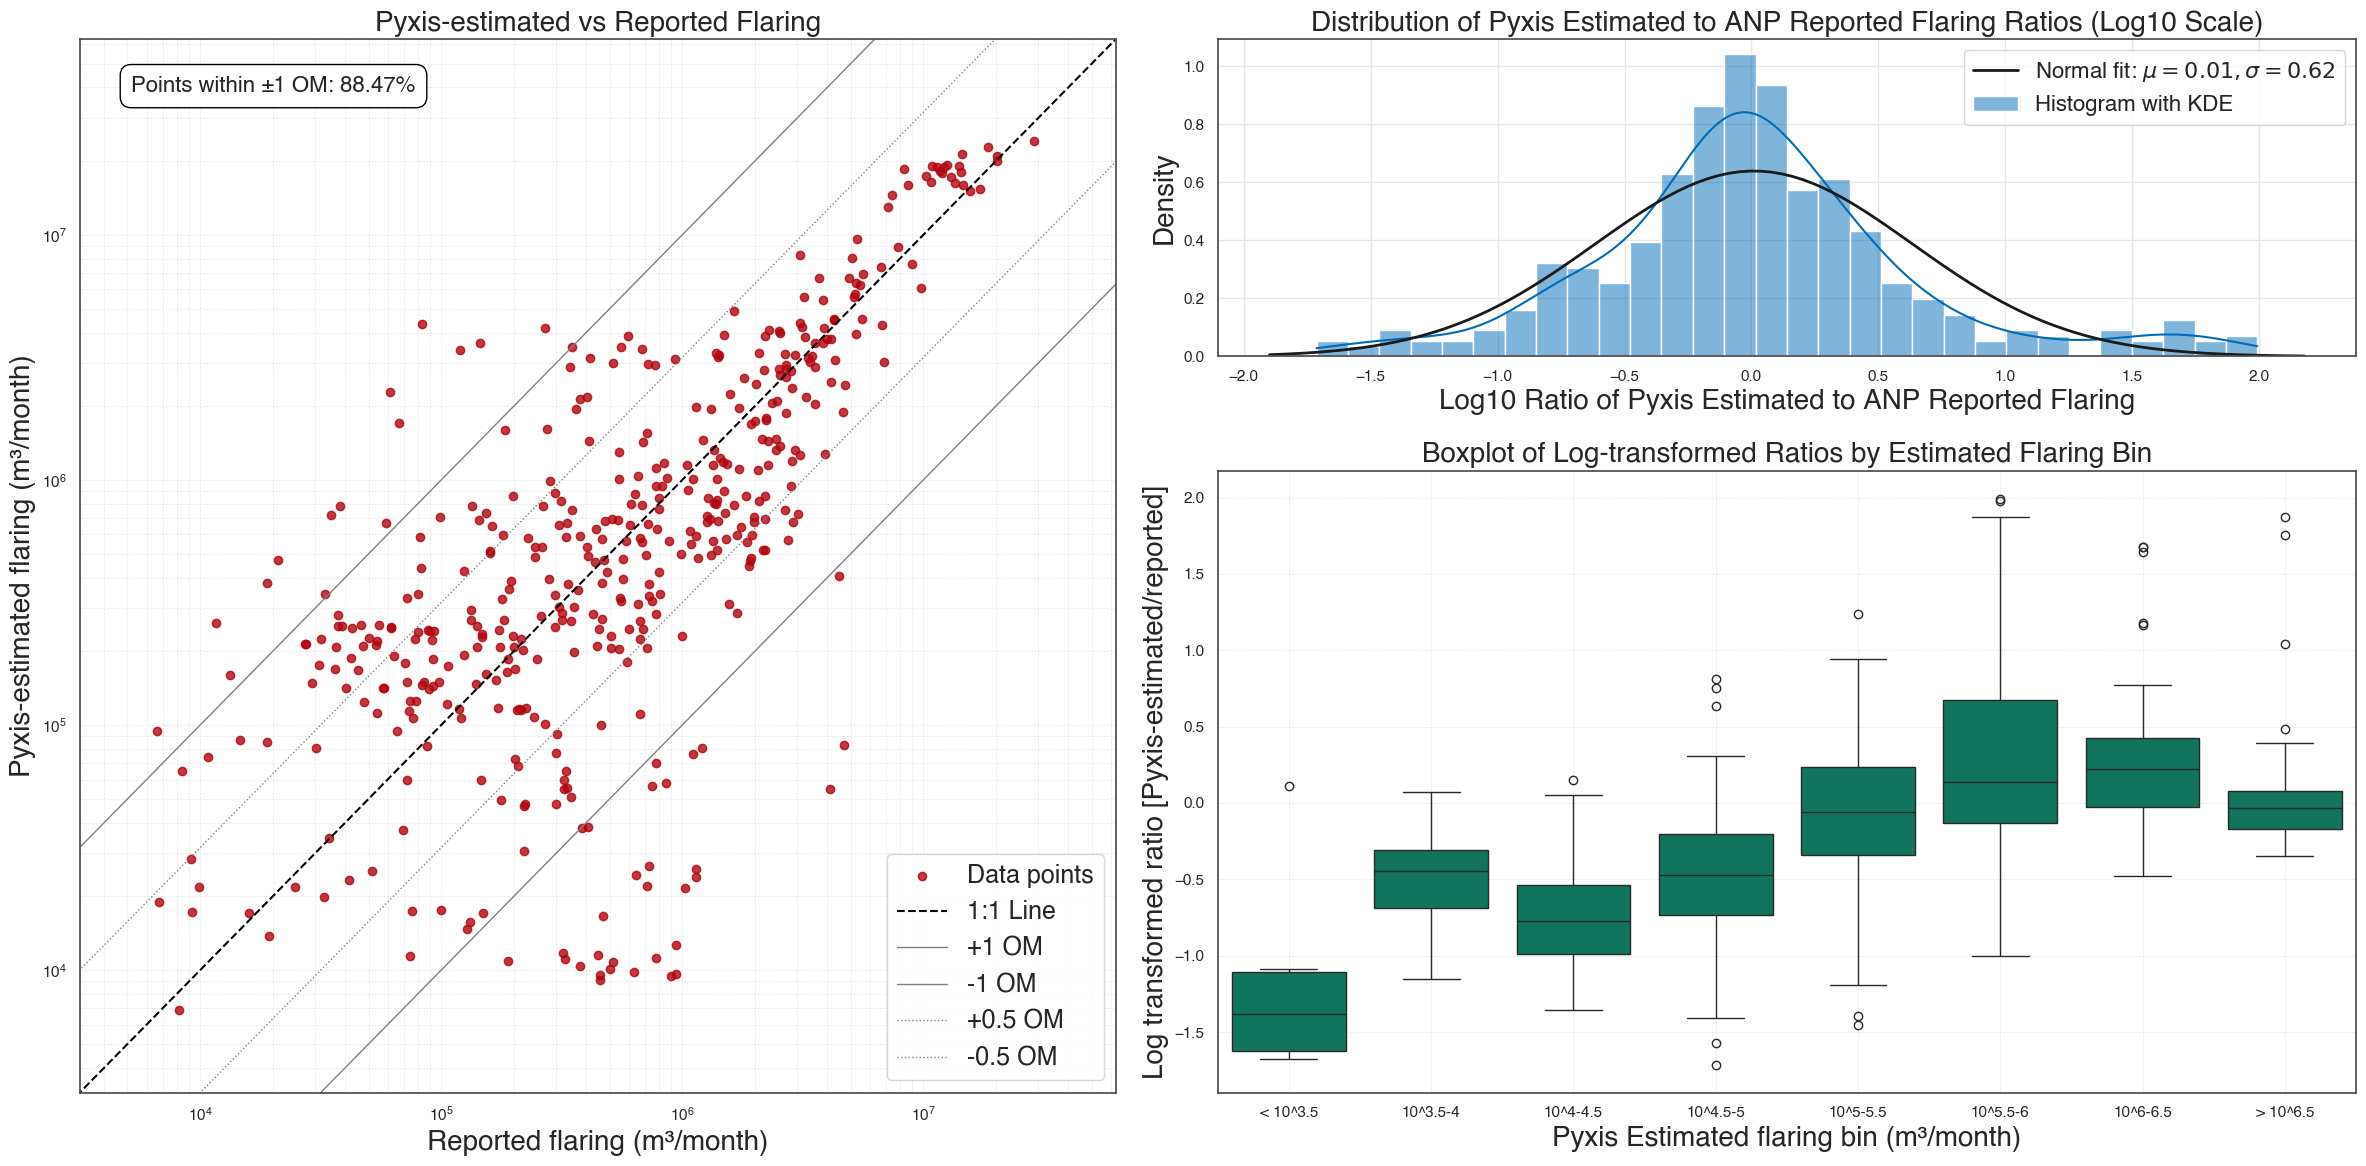

In [78]:
plt.rcParams['font.size'] = 18

def combined_flare_plot(satellite_data, anp_data):
    # Merge satellite and ANP data for comparison
    merged_data = pd.merge(satellite_data, anp_data, left_on=['Field name', 'month'], right_on=['Field', 'month'], how='inner')

    # Clean the resulting dataset by removing rows where either flare volume is zero
    merged_data = merged_data[(merged_data['flare_volume_x'] > 0) & (merged_data['flare_volume_y'] > 0)]

    # Count the number of observations
    observation_count = len(merged_data)
    print(f'Number of Observations: {observation_count}')

    # Calculate the points that are within 1 OM
    within_1_OM = merged_data[
        (merged_data['flare_volume_y'] <= merged_data['flare_volume_x'] * 10) &
        (merged_data['flare_volume_y'] >= merged_data['flare_volume_x'] / 10)
    ]
    percent_within_1_OM = len(within_1_OM) / len(merged_data) * 100

    # Set up the subplots
    fig = plt.figure(figsize=(24, 12))
    gs = fig.add_gridspec(3, 3, height_ratios=[2.5, 1.5, 2.5], width_ratios=[2, 1, 1])

    # Scatter plot (Top-left, spans three rows)
    ax0 = fig.add_subplot(gs[:, 0])
    ax0.scatter(merged_data['flare_volume_x'], merged_data['flare_volume_y'], alpha = 0.8, color='#B1040E', label='Data points')
    ax0.plot([10**2, 10**8], [10**2, 10**8], color='black', linestyle='--', linewidth=1.5, label='1:1 Line')
    ax0.plot([10**2, 10**8], [10**3, 10**9], color='grey', linestyle='-', linewidth=1, label='+1 OM')
    ax0.plot([10**2, 10**8], [10**1, 10**7], color='grey', linestyle='-', linewidth=1, label='-1 OM')
    ax0.plot([10**2, 10**8], [10**2 * np.sqrt(10), 10**8 * np.sqrt(10)], color='grey', linestyle=':', linewidth=1, label='+0.5 OM')
    ax0.plot([10**2, 10**8], [10**2 / np.sqrt(10), 10**8 / np.sqrt(10)], color='grey', linestyle=':', linewidth=1, label='-0.5 OM')
    
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_xlim([10**3.5, 10**7.8])
    ax0.set_ylim([10**3.5, 10**7.8])
    ax0.set_xlabel('Reported flaring (m³/month)', fontsize=20)
    ax0.set_ylabel('Pyxis-estimated flaring (m³/month)', fontsize=20)
    ax0.set_title('Pyxis-estimated vs Reported Flaring', fontsize=20)
    ax0.legend(loc='lower right', fontsize=18)
    ax0.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax0.annotate(f'Points within ±1 OM: {percent_within_1_OM:.2f}%', xy=(0.05, 0.95), xycoords='axes fraction', 
                 fontsize=16, backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # Log10 transformed distribution plot with fitted line (Top-right, smaller size)
    ax1 = fig.add_subplot(gs[0, 1:])
    merged_data['log_ratio'] = np.log10(merged_data['flare_volume_x'] / merged_data['flare_volume_y'])
    sns.histplot(merged_data['log_ratio'], bins=30, ax=ax1, color='#006CB8', kde=True, stat="density", label="Histogram with KDE")
    ax1.set_xlabel('Log10 Ratio of Pyxis Estimated to ANP Reported Flaring', fontsize=20)
    ax1.set_ylabel('Density', fontsize=20)
    ax1.set_title('Distribution of Pyxis Estimated to ANP Reported Flaring Ratios (Log10 Scale)', fontsize=20)
    
    # Fit a normal distribution line for log-transformed data
    log_mu, log_std = norm.fit(merged_data['log_ratio'])
    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, log_mu, log_std)
    ax1.plot(x, p, 'k', linewidth=2, label=f'Normal fit: $μ={log_mu:.2f}, σ={log_std:.2f}$')
    ax1.legend(fontsize=16)

    # Estimated flaring bin plot (Bottom-right, larger size)
    ax2 = fig.add_subplot(gs[1:, 1:])
    merged_data['estimated_bin'] = pd.cut(merged_data['flare_volume_x'], bins=[0, 10**3.5, 10**4, 10**4.5, 10**5, 10**5.5, 10**6, 10**6.5, np.inf], labels=['< 10^3.5','10^3.5-4', '10^4-4.5', '10^4.5-5', '10^5-5.5', '10^5.5-6', '10^6-6.5', '> 10^6.5'])
    sns.boxplot(x='estimated_bin', y='log_ratio', data=merged_data, ax=ax2, color='#008566')
    ax2.set_xlabel('Pyxis Estimated flaring bin (m³/month)', fontsize=20)
    ax2.set_ylabel('Log transformed ratio [Pyxis-estimated/reported]', fontsize=20)
    ax2.set_title('Boxplot of Log-transformed Ratios by Estimated Flaring Bin', fontsize=20)
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # Adjust layout
    plt.tight_layout()
    plt.savefig('../data/br_geodata/plots/Flare_validation.png', format='png', dpi=300)
    plt.show()

combined_flare_plot(satellite_data, anp_data)
